## packages

In [1]:
import os, sys, time, warnings

warnings.filterwarnings('ignore')
sys.path.append("..")

from addict import Dict

from glob import glob
import argparse
from argparse import ArgumentParser

from toolz import *
from toolz.curried import *
from toolz.curried.operator import *

import numpy as np
import torch
import torch.nn.functional as F

from data.dataloader import DATALOADER
from models.baseline import NETS

from utils import COMPUTE_METRIC

In [2]:
def parse():
    
    parser = ArgumentParser()

    parser.add_argument("--ckpt_path", type=str, default="./ckpts")
    
    parser.add_argument("--encoder_name", type=str, default="AlexNet", help = "AlexNet | VGGNet | ResNet | ViT | ConvNext") # in order of increasing performance
    parser.add_argument("--input_size", type=int, default=224)    
    parser.add_argument("--code_size", type=int, default=512)    
                        
    parser.add_argument("--batch_size", type=int, default = 100)
    parser.add_argument("--num_workers", type=int, default = 8)
    
    # get args
    args = first(parser.parse_known_args())
    
    # pick a gpu that has the largest space
    os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        
    return args

args = parse()

## dataloader

In [3]:
chexpert_loader =\
DATALOADER(data_path   = "../data/datasets/stanford-chexpert/",
           labels      = ['Pneumonia', 'No Finding', 'Lung Opacity','Lung Lesion','Consolidation'],
           source      = "chexpert", 
           shape       = args.input_size,
           batch_size  = args.batch_size,
           num_workers = args.num_workers,
           mode        = "valid")

mimic_loader =\
DATALOADER(data_path   = "../data/datasets/mit/",
           labels      = ['pneumonia', 'no finding', 'airspace opacity', 'lung lesion','consolidation'],
           source      = "mimic", 
           shape       = args.input_size,
           batch_size  = args.batch_size,
           num_workers = args.num_workers,
           mode        = "valid")

## models (alex:vanilla, alex:rubust)

In [103]:
def loadWeights(model, ckptPath):
    
    checkpoint = torch.load(ckptPath, map_location = lambda x,y : x)
    checkpoint = keymap(lambda x : x.replace("net.", ""))(checkpoint['state_dict'])
    model.load_state_dict(checkpoint)
    
    return model

baseline = NETS("AlexNet",
                [args.input_size]*2,
                14,
                args.code_size)

baseline = loadWeights(baseline, "../ckpts/AlexNet/model:AlexNet|u0.ckpt")


proposed = NETS("AlexNet_win",
                [args.input_size]*2,
                14,
                args.code_size)

proposed = loadWeights(proposed, "../ckpts/AleNet_win/model:AlexNet_win.ckpt")

## predict

In [104]:
# def diagnosticRule (ys, yhats):

#     Pyhats1, Pyhats2, *Pyhats3 = list(yhats)
#     Pys1,    Pys2,    *Pys3    = list(ys)
    
#     #newys = [Pys1, Pys2, 1]
#     #newyhat = [Pyhats1, Pyhats2, int(any(list(np.int(np.array(Pyhats3)>0.5) == np.array(Pys3))))]
    
#     newys = [Pys1, Pys2]
    
#     return newys, newyhat
    
def predict (dataLoader, model):

    model.eval().cuda()
    
    yss    = [] 
    yHatss = []
    
    for i, sample in enumerate(dataLoader):
        
        Xs, ys = sample

        logits = model(Xs.cuda())
        
        yHats = logits.detach().cpu()
        
        # ys, yHats = [diagnosticRule(_ys.detach().cpu().numpy(),
        #                             np.array([_yHats[0],_yHats[3],_yHats[4],_yHats[6],_yHats[7]])) for _ys, _yHats in zip(ys, yHats)]
        
        ys = ys.detach().cpu()
        
        yss    = yss    + list(torch.stack([ys[:,0], ys[:,0]], -1).numpy())
        yHatss = yHatss + list(torch.stack([yHats[:,0], ys[:,0]], -1).numpy())
        
        if i%100 == 0:
            print(f"{i}'th iteration done")
            
    del model
            
    return yss, yHatss

# alexnet_robust + chexpert
yss_arc, yHatss_arc = predict(chexpert_loader, proposed)

# # alexnet_robust + mimic
yss_arm, yHatss_arm = predict(mimic_loader, proposed)

# # alexnet + chexpert
yss_ac, yHatss_ac = predict(chexpert_loader, baseline)

# # alexnet + mimic
yss_am, yHatss_am = predict(mimic_loader, baseline)

0'th iteration done
0'th iteration done
0'th iteration done
0'th iteration done


## ROC AUC

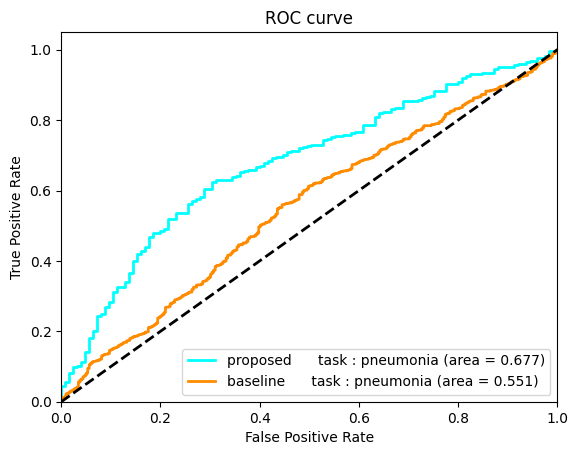

In [116]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import csv
import sys
import numpy as np
import itertools

def plt_roc(y_pred, y_label, class_name, modelName, color):
    """
    plot the roc curve for the multi-classification 
    plot 3 classes result from the same model in the same image
    """
    # y_pred (0,1) prob for 14 classes, list
    # y_lable 0,1,2,..,13, list

    tfpr, ttpr, _ = roc_curve(y_label, y_pred)
    troc_auc = auc(tfpr, ttpr)

    # Plot all ROC curves    
    plt.plot(
        ttpr,        
        tfpr,
        color=color,
        lw=2,
        label=f"{modelName}      task : {class_name} (area = {str(1-troc_auc)[:5]})"
    )


plt.figure()    

yHatss_arm = yHatss_arm + yHatss_arc
yss_arm    = yss_arm + yss_arc

yHatss_am  = yHatss_am + yHatss_ac
yss_am     = yss_am    + yss_ac


#['pneumonia', 'no finding', 'airspace opacity', 'lung lesion','consolidation']    
plt_roc(np.array(yHatss_arm)[:,0], np.array(yss_arm, dtype = bool)[:,0], "pneumonia", "proposed", "aqua")
plt_roc(np.array(yHatss_am)[:,0], np.array(yss_am, dtype = bool)[:,0], "pneumonia", "baseline", "darkorange")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

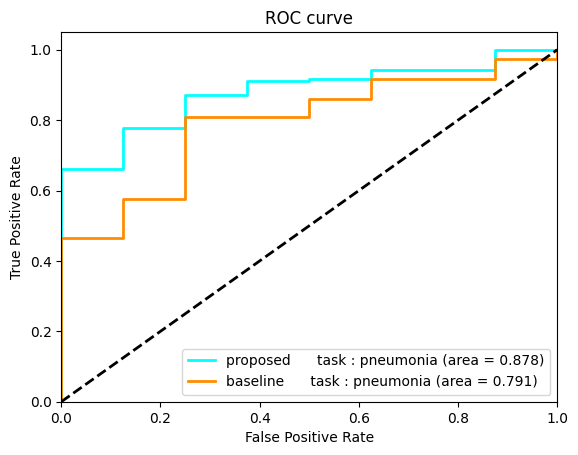

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import csv
import sys
import numpy as np
import itertools

def plt_roc(y_pred, y_label, class_name, modelName, color):
    """
    plot the roc curve for the multi-classification 
    plot 3 classes result from the same model in the same image
    """
    # y_pred (0,1) prob for 14 classes, list
    # y_lable 0,1,2,..,13, list

    tfpr, ttpr, _ = roc_curve(y_label, y_pred)
    troc_auc = auc(tfpr, ttpr)

    # Plot all ROC curves    
    plt.plot(
        ttpr,        
        tfpr,
        color=color,
        lw=2,
        label=f"{modelName}      task : {class_name} (area = {str(1-troc_auc)[:5]})"
    )


plt.figure()    

#['pneumonia', 'no finding', 'airspace opacity', 'lung lesion','consolidation']    
plt_roc(np.array(yHatss_arc)[:,0], np.array(yss_arc, dtype = bool)[:,0], "pneumonia", "proposed", "aqua")
plt_roc(np.array(yHatss_ac)[:,0], np.array(yss_ac, dtype = bool)[:,0], "pneumonia", "baseline", "darkorange")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
num_sample = 100#100
num_model = 3
y_preds = []
y_labels = []
######### 14classes 100sampless

for j in range(num_model):
    y_pred = []
    y_label = []
    for i in range(num_sample):
        a = np.random.dirichlet(np.ones(14),size=1)
        #print(a)
        y_pred.append(a[0])

        # generate lable
        x = np.random.uniform(0,1,1)
        if x < 0.60:
            y_label.append(np.argmax(a[0]))
        else:
            y_label.append(np.random.randint(0,13))

    y_pred = np.array(y_pred)
    y_label = np.array(y_label)
    y_preds.append(y_pred)
    y_labels.append(y_label)

In [ ]:
draw_averroc(y_preds,  y_labels)

In [ ]:
draw_averroc([np.array(yHatss_arc)], [np.array(yss_arc)[:,0]])

In [ ]:
y_preds[0].shape

## ROC AUC, Precision recall (trained & tested on Chexpert)

## ROC AUC, Precision recall (trained on Chexpert & tested on Mimic)